In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls drive/My\ Drive/GAN_images

15000回.png	   dcgan_mnist_4.png  mnist_0.png  mnist_6.png
5000回.png	   dcgan_mnist_5.png  mnist_1.png  mnist_7.png
dcgan_mnist_0.png  dcgan_mnist_6.png  mnist_2.png  mnist_8.png
dcgan_mnist_1.png  dcgan_mnist_7.png  mnist_3.png  mnist_9.png
dcgan_mnist_2.png  dcgan_mnist_8.png  mnist_4.png
dcgan_mnist_3.png  dcgan_mnist_9.png  mnist_5.png


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 512)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.692523, acc.: 30.00%] [G loss: 0.678196]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.410449, acc.: 76.50%] [G loss: 4.417693]
200 [D loss: 0.600496, acc.: 61.50%] [G loss: 1.871786]
300 [D loss: 0.591968, acc.: 64.50%] [G loss: 1.753206]
400 [D loss: 0.577627, acc.: 66.00%] [G loss: 1.646880]
500 [D loss: 0.579884, acc.: 72.00%] [G loss: 1.727760]
600 [D loss: 0.555061, acc.: 68.50%] [G loss: 1.409661]
700 [D loss: 0.621098, acc.: 60.50%] [G loss: 1.342699]
800 [D loss: 0.598813, acc.: 64.00%] [G loss: 1.613966]
900 [D loss: 0.507939, acc.: 73.00%] [G loss: 1.387255]


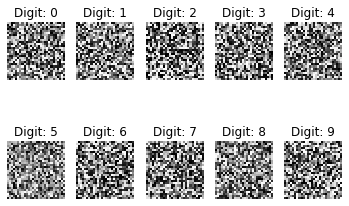

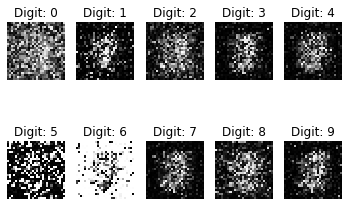

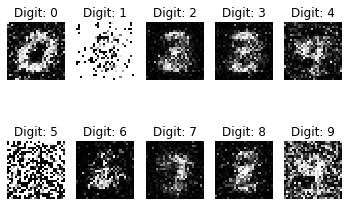

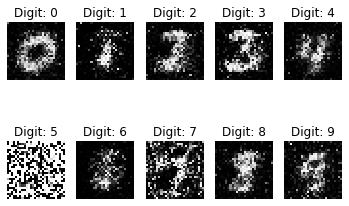

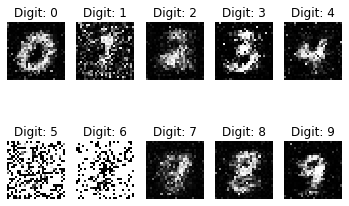

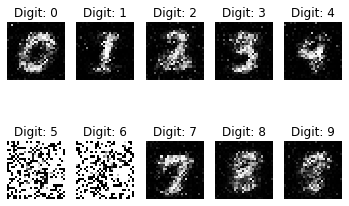

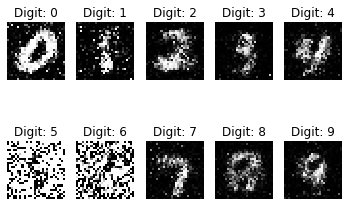

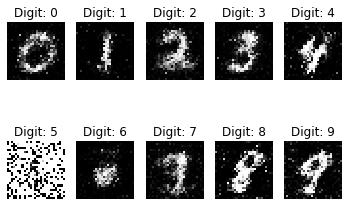

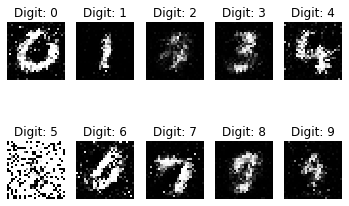

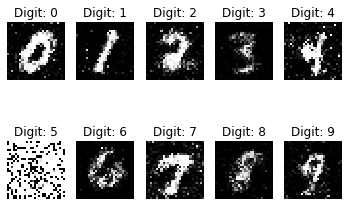

In [26]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self):
        # 入力画像の形の定義（Input shape）
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        # 最適化関数
        optimizer = Adam(0.0002, 0.5)

        # discriminatorモデルの構築
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])
        
        self.discriminator.trainable = False
        valid = self.discriminator([img, label])

        # generatorモデルの構築
        self.generator = self.build_generator()

        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)


        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        
    def build_generator(self):

        # モデルの形は普通のGANと同じ（入力の形は100）
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        # inputにランダムノイズとラベルを入れる！
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)



    def build_discriminator(self):
　　
        # モデルの形は普通のGANと同じ（入力の形は100）
        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()


        # inputにランダムノイズとラベルを入れる！
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)



    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # 学習データから画像とラベルのセットを作る
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Gモデルに、ノイズとラベルを与えFake画像を作らせる
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # ランダムノイズとランダムなラベルのペアを元に、パラメータ調整し学習していく
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)


    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
  
        fig, axs = plt.subplots(r, c)
       
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1


if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=1000, batch_size=100, sample_interval=100)

# 結果
- 5の生成が失敗した（ラベルをランダムでとるため、5を入力することが偶然少なかったのかもしれない）
- DCGANに比べて（同じくらいの精度を出すためには）学習回数を10倍以上増やさないといけない（ラベルごとに学習させるから？わからない）

In [0]:
def rec(i):
  print(i)
  if i == 0: 
    return 1
  else:
    ans = 0;
    if i >= 1:
      ans += rec(i-1)
    if i >= 2:
      ans += rec(i-2)
    if i >= 3:
      ans += rec(i-3)
    return ans

def solve(n):
  return rec(n)

In [17]:
print(solve(5))

5
4
3
2
1
0
0
1
0
0
2
1
0
0
1
0
3
2
1
0
0
1
0
0
2
1
0
0
13
